In [1]:
import gluon
import view_gluon

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.optimize as so

import utils
import gvar as gv

utils.set_mplstyle()

In [2]:
escale = 1.7606
Tc=167

# Create color dictionary for plotting
c = {}

for pos,Nt in enumerate([8,12,16,20,24,28,32,36,40,48,56,64,128]):
    #c[Nt] = f"C{pos}"
    c[Nt] = mpl.cm.tab20(pos)

In [3]:
def renorm(q,D_latt,D_tree):
    
    renorm_fit = lambda x,h: h*D_tree
    #renorm_fit = lambda x,h: h*D_tree*((2/np.pi)*np.arctan(3.453*np.pi/q))
    
    popt,pcov = so.curve_fit(renorm_fit,q,np.asarray([D.mean for D in D_latt]),sigma=np.asarray([D.sdev for D in D_latt]),absolute_sigma=True)
    
    return 1/gv.gvar(popt[0],np.sqrt(pcov[0][0]))
    

# Compare modes

# Compare temperatures

In [4]:
mode = "VRS"

In [5]:
results = {}

#for Nt in [8, 12, 16, 24, 32,64]: 
for Nt in [8,12,16,24,32,64,128]:
    try:
        prop = view_gluon.propagator(Nt,mode,n_samples=50,gtype="coulomb")
    except: continue
    print(Nt,len(prop.prop_info))
    q = prop.q
    D = prop.D
    
    # Z3 average
    qz3, Dz3 = prop.Z3_average(q,D)
    
    # _,_ = prop.half_cut()
    
    prop.q = qz3
    prop.D = Dz3
    
    # Cone cut
    qc, Dc = prop.cone_cut(radius=1)
    
    # Lattice momentum correction
    qi = prop.correct_q(qc,qtype="improved")
    
    # Renormalize
    prop.renormalize(xi=3.453)
    
    results[Nt] = {'f':prop.f.copy(), 'D': prop.D.copy(),'alpha':prop.alpha,'q':qi, 'Nconf':len(prop.prop_info), 'chisq': prop.chisq, 'prop_info': prop.prop_info}


8 50


/home/ben/Work/gluon-prop/view_gluon.py:110: RuntimeWarning: divide by zero encountered in divide
  z = xi*p0/norm_p


12 50


/home/ben/Work/gluon-prop/view_gluon.py:110: RuntimeWarning: divide by zero encountered in divide
  z = xi*p0/norm_p


16 50


/home/ben/Work/gluon-prop/view_gluon.py:110: RuntimeWarning: divide by zero encountered in divide
  z = xi*p0/norm_p


24 50


/home/ben/Work/gluon-prop/view_gluon.py:110: RuntimeWarning: divide by zero encountered in divide
  z = xi*p0/norm_p


32 50


/home/ben/Work/gluon-prop/view_gluon.py:110: RuntimeWarning: divide by zero encountered in divide
  z = xi*p0/norm_p


64 50


/home/ben/Work/gluon-prop/view_gluon.py:110: RuntimeWarning: divide by zero encountered in divide
  z = xi*p0/norm_p


128 50


/home/ben/Work/gluon-prop/view_gluon.py:110: RuntimeWarning: divide by zero encountered in divide
  z = xi*p0/norm_p


8 1.012(11) 50 0.0443092762394(14)
12 0.9985(56) 50 0.03074094785666(59)
16 1.0050(35) 50 0.04560041779405(28)
24 1.0000(20) 50 0.03459085964610(15)
32 1.0003(14) 50 0.03667525416444(11)
64 0.99940(65) 50 0.039857566746896(63)
128 1.00001(31) 50 0.13994923975901(22)


Text(0.5, 0, '$T/T_c$')

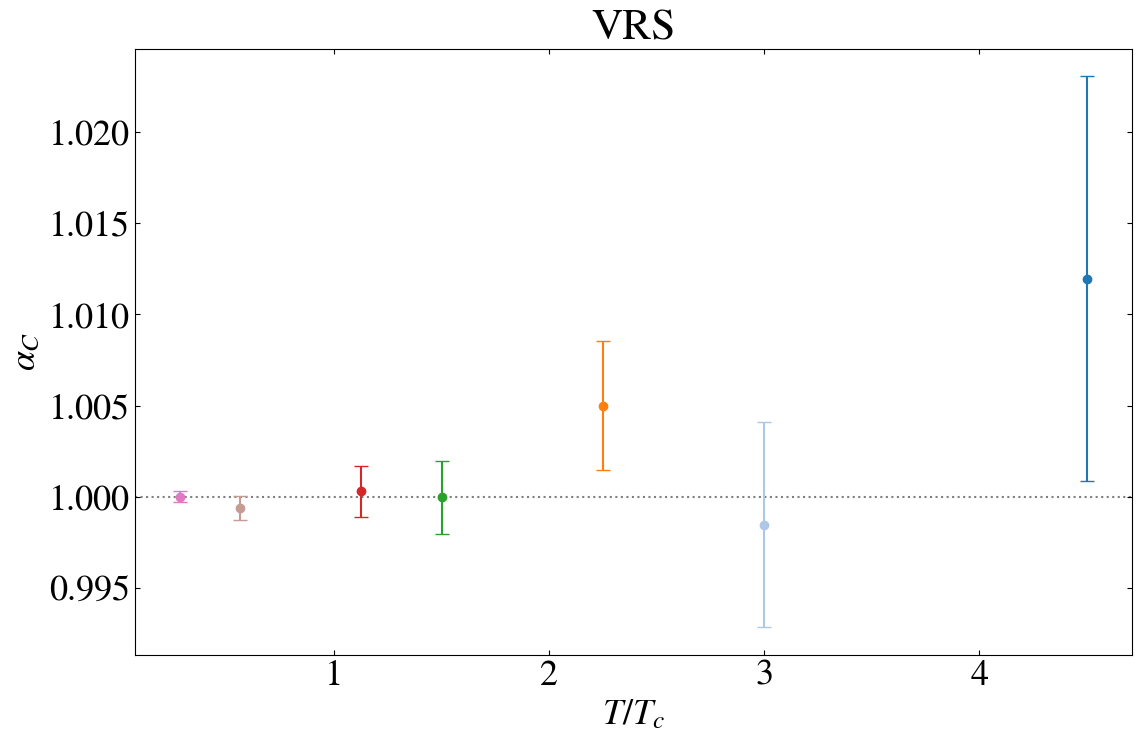

In [6]:
plt.figure(figsize=(12,8))
ax = plt.gca()

for temp in results.keys():
    print(temp, results[temp]['alpha'] , results[temp]['Nconf'], results[temp]['chisq'])
    plt.errorbar(36/temp,results[temp]['alpha'].mean,results[temp]['alpha'].sdev,zorder=10,fmt='o',c=c[temp])
    
ax.axhline(1,0,1,ls=':',c='k',alpha=0.5)
plt.title(f"{mode}")
plt.ylabel("$\\alpha_C$")
plt.xlabel("$T/T_c$")

0.714(48) 0.7038(53) 0.5641(43)
0.725(41) 0.7279(45) 0.5833(36)
0.722(35) 0.7214(39) 0.5782(31)
0.705(27) 0.7070(31) 0.5667(25)
0.696(23) 0.7053(27) 0.5653(21)
0.698(16) 0.6991(19) 0.5603(15)
0.701(11) 0.6999(13) 0.5610(10)


(0.0, 1.0)

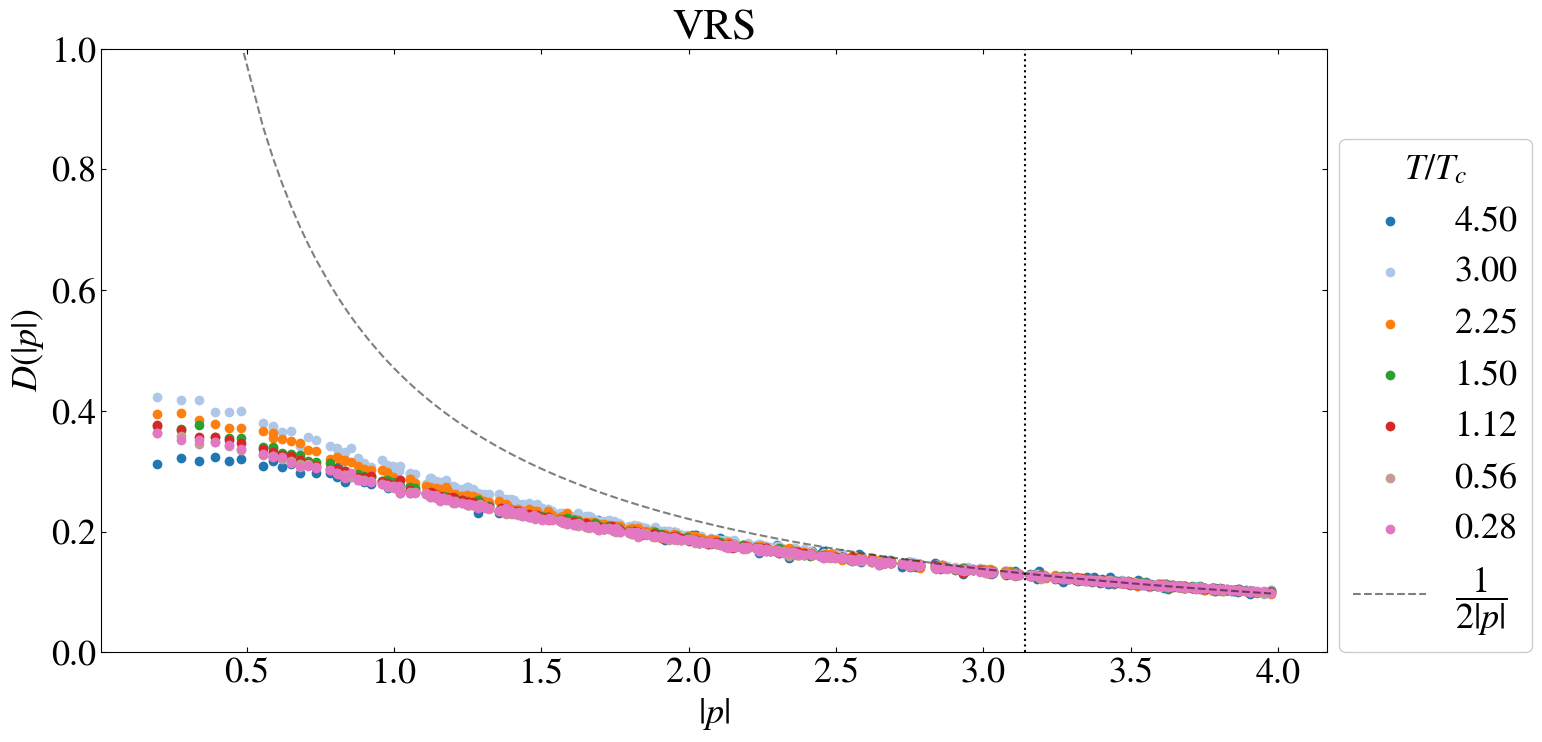

In [7]:
plt.figure(figsize=(16,8))
ax = plt.gca()

Z_naive_list = []
Z_fit_list = []
Z_naive_arctan_list = []
Z_fit_arctan_list = []

for pos,Nt in enumerate(results.keys()):
    q = results[Nt]['q'].copy()
    q = np.asarray([np.linalg.norm(qi[1:]) for qi in q[q[:,0]==0][1:]])
    D = results[Nt]['f'].copy()
    
    renorm_mu = -58
    
    mu = q[renorm_mu]
    
    if mode in ["VRS","UT","VR"]:
        Z_naive = 1/(D[renorm_mu]*mu*2)
        Z_naive_arctan = np.arctan(np.pi*3.453/mu)/(D[renorm_mu]*mu*np.pi)
        
        D_tree_atan = 1/(np.pi*q) * np.arctan(np.pi*3.453/q)
        D_tree = 1/(2*q)
        
        Z_fit = renorm(q[q>np.pi],D[q>np.pi],D_tree[q>np.pi])
        Z_arctan = renorm(q[q>np.pi],D[q>np.pi],D_tree_atan[q>np.pi])
        
        print(Z_naive, Z_fit,Z_arctan)
        
        Z_naive_list.append(Z_naive)
        Z_naive_arctan_list.append(Z_naive_arctan)
        Z_fit_list.append(Z_fit)
        Z_fit_arctan_list.append(Z_arctan)
    
        D *= Z_arctan
    
    label = f"{36/Nt:.2f}"
    
    ax.scatter(q,np.asarray([d.mean for d in D]),label=label,ls='-',color=c[Nt])
    #ax.errorbar(q+0.01*pos,np.asarray([d.mean for d in D]),np.asarray([d.sdev for d in D]),label=label,ls='',errorevery=4,)

if mode in ["VRS","UT","VR"]:
    sort = np.argsort(q)
    ax.plot(q[sort],D_tree_atan[sort],c='k',ls='--',alpha=0.5,label="$\dfrac{1}{2|p|}$")
    
    ax.axvline(np.pi,0,1,ls=':',c='k')
#ax.axhline(1/(2*mu),0,1,c='k',alpha=0.3)

plt.title(f"{mode}")    
plt.legend(loc=(1.01,0),title='$T/T_c$')
plt.ylabel('$D(|p|)$')
#plt.yticks([])
plt.xlabel('$|p|$')
plt.ylim(0,1)
#plt.yscale('log')

In [8]:
if mode == "VOS":

    plt.figure(figsize=(16,8))
    ax = plt.gca()

    for pos,Nt in enumerate([8,32,64,128]):
        q = results[Nt]['q'].copy()
        q = np.asarray([np.linalg.norm(qi[1:]) for qi in q[q[:,0]==0][1:]])
        D = results[Nt]['f'].copy()
 
        label = f"{36/Nt:.2f}"
    
        ax.errorbar(1/q,np.asarray([d.mean for d in D]),np.asarray([d.sdev for d in D]),label=label,ls='',marker='o',c=c[Nt])

    plt.title(f"{mode}")    
    plt.legend(loc=(1.01,0),title='$T/T_c$')
    plt.ylabel('$D(|p|)$')
    #plt.yticks([])
    plt.xlabel('$1/|p|$')
    #plt.yscale('log')
else:
    print("This plot is for VOS only.")

This plot is for VOS only.


In [9]:
Z_naive_VRS = [gv.gvar(z) for z in ["0.683(62)", "0.724(57)", "0.713(50)", "0.696(38)", "0.702(34)", "0.700(23)", "0.702(16)"]]
Z_fit_VRS = [gv.gvar(z) for z in ["0.7029(53)", "0.7272(45)", "0.7214(39)", "0.7063(31)", "0.7048(27)", "0.7004(19)", "0.6990(13)"]]
Z_naive_arctan_VRS = [gv.gvar(z) for z in ["0.552(51)", "0.586(46)", "0.577(40)", "0.563(30)", "0.568(27)", "0.567(19)", "0.568(13)"]]
Z_fit_arctan_VRS = [gv.gvar(z) for z in ["0.5634(43)", "0.5829(36)", "0.5782(31)", "0.5661(25)", "0.5649(21)", "0.5614(15)", "0.5603(10)"]]

Z_naive_UT = ["0.799(73)", "0.789(61)", "0.787(52)", "0.801(43)", "0.787(38)", "0.790(26)", "0.789(18)"]
Z_fit_UT = ["0.7975(60)", "0.8067(50)", "0.8057(43)", "0.8091(35)", "0.8068(30)", "0.8044(21)", "0.8041(15)"]
Z_naive_arctan_UT = ["0.647(59)", "0.639(49)", "0.637(42)", "0.649(35)", "0.637(31)", "0.640(21)", "0.638(15)"]
Z_fit_arctan_UT = ["0.6387(48)", "0.6460(40)", "0.6451(34)", "0.6480(28)", "0.6461(24)", "0.6442(17)", "0.6439(12)"]

In [10]:
if mode == "VOS":

    plt.figure(figsize=(16,8))
    ax = plt.gca()

    for pos,Nt in enumerate([8,32,64,128]):
        q = results[Nt]['q'].copy()
        q = np.asarray([np.linalg.norm(qi[1:]) for qi in q[q[:,0]==0][1:]])
        D = results[Nt]['f'].copy()
 
        label = f"{36/Nt:.2f}"
    
        ax.errorbar(1/q,np.asarray([d.mean for d in D]),np.asarray([d.sdev for d in D]),label=label,ls='',marker='o',c=c[Nt])

    plt.title(f"{mode}")    
    plt.legend(loc=(1.01,0),title='$T/T_c$')
    plt.ylabel('$D(|p|)$')
    #plt.yticks([])
    plt.xlabel('$1/|p|$')
    #plt.yscale('log')
else:
    print("This plot is for VOS only.")

This plot is for VOS only.


[0.714(48), 0.725(41), 0.722(35), 0.705(27), 0.696(23), 0.698(16), 0.701(11)]
[0.7038(53), 0.7279(45), 0.7214(39), 0.7070(31), 0.7053(27), 0.6991(19), 0.6999(13)]
[0.567(38), 0.576(32), 0.574(28), 0.560(21), 0.552(18), 0.554(13), 0.5570(90)]
[0.5641(43), 0.5833(36), 0.5782(31), 0.5667(25), 0.5653(21), 0.5603(15), 0.5610(10)]


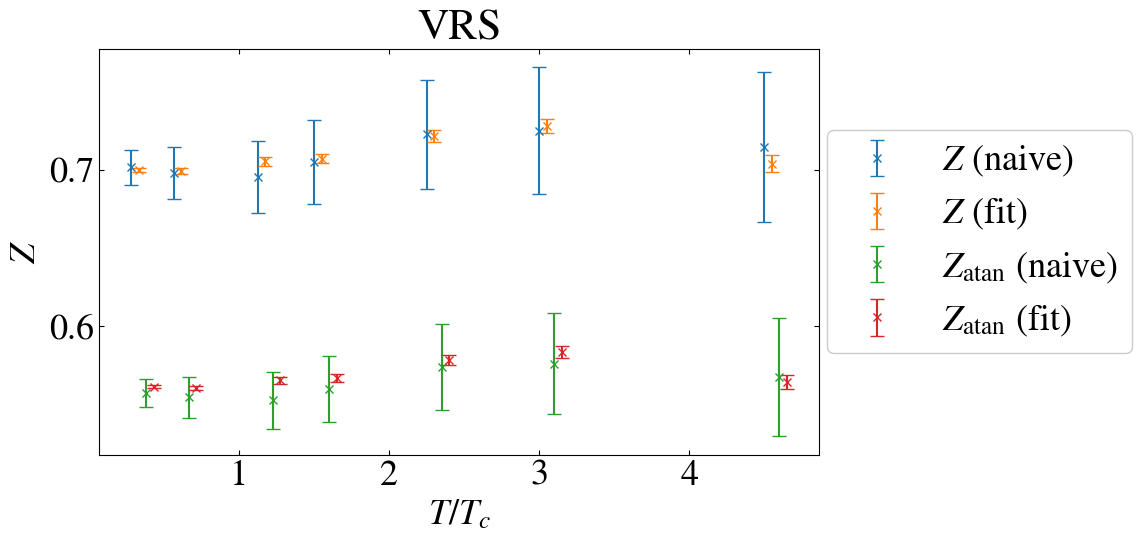

In [11]:
if mode != "VOS":

    plt.figure(figsize=(12,6))

    labels = ["$Z$ (naive)","$Z$ (fit)","$Z_\mathrm{atan}$ (naive)","$Z_\mathrm{atan}$ (fit)"]

    for pos,zlist in enumerate([Z_naive_list, Z_fit_list,Z_naive_arctan_list,Z_fit_arctan_list]):
        print(zlist)
        plt.errorbar([36/i+0.05*pos for i in results.keys()],[z.mean for z in zlist],[z.sdev for z in zlist],label=labels[pos],ls='',fmt='x')
    
    plt.title(f"{mode}")
    plt.legend(loc=(1.01,0.25))
    plt.ylabel("$Z$")
    plt.xlabel("$T/T_c$")
    
else:
    print("VOS does not have associated renormalization factor plot.")

Text(0.5, 0, '$|p|$')

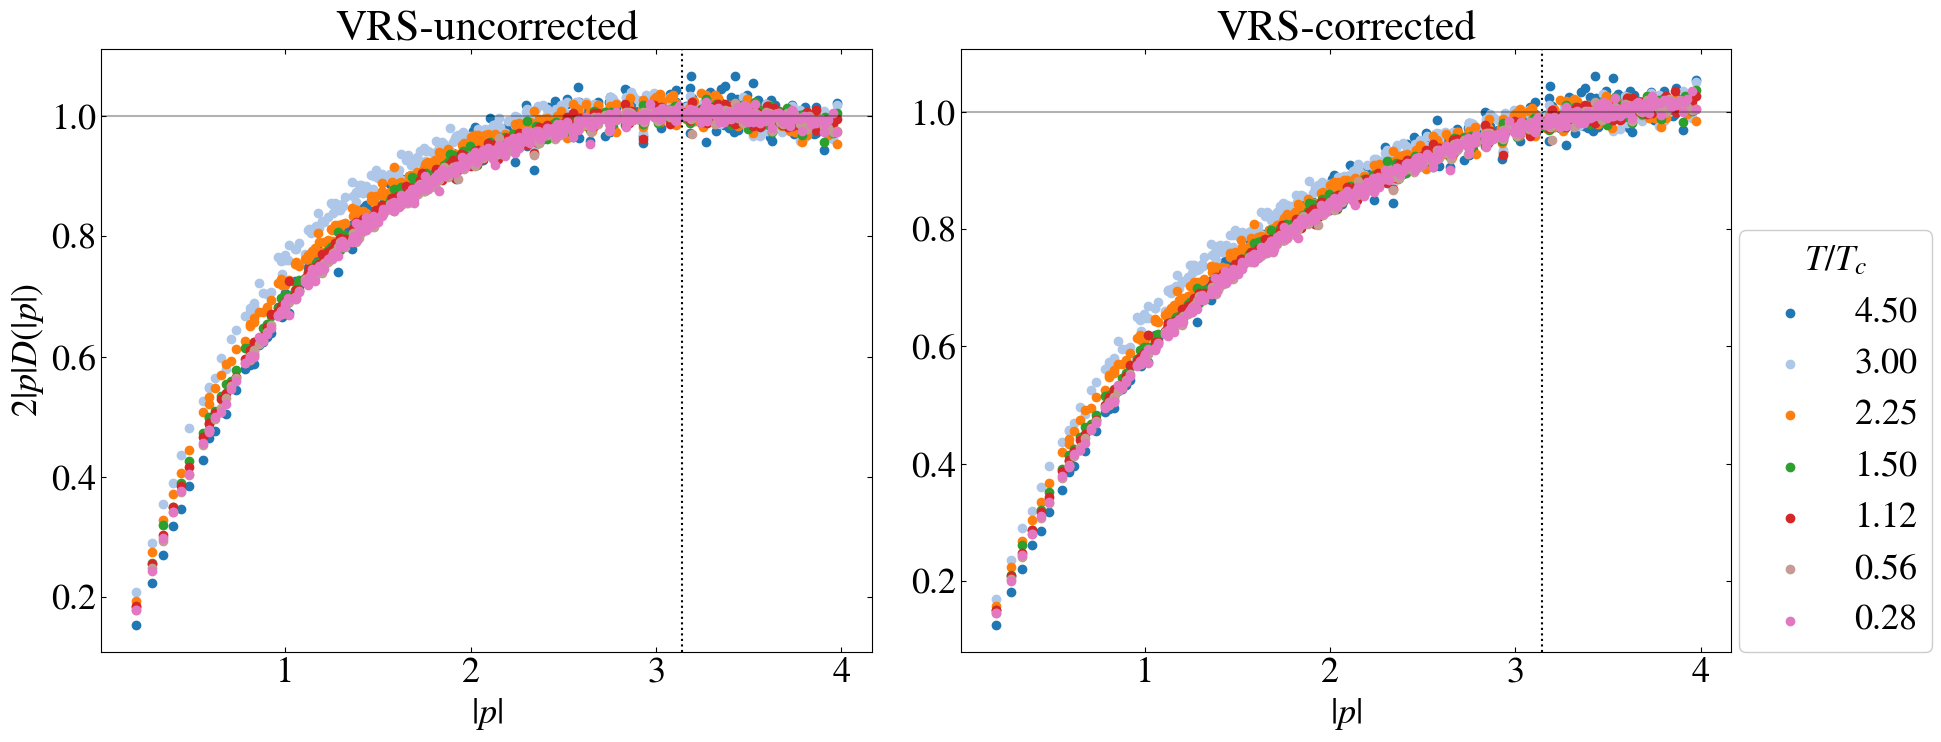

In [12]:
fig, ax = plt.subplots(1,2,figsize=(20,8))

renorm_mu = -50

for pos,Nt in enumerate(results.keys()):
    q = results[Nt]['q'].copy()
    q = np.asarray([np.linalg.norm(qi[1:]) for qi in q[q[:,0]==0][1:]])
    D = results[Nt]['f'].copy()
    
    mu = q[renorm_mu]
    
    D_tree = 1/(2*q)
    D_tree_atan = 1/(np.pi*q) * np.arctan(np.pi*3.453/q)

        
    Z_tree = renorm(q[q>np.pi],D[q>np.pi],D_tree[q>np.pi])
    Z_tree_atan = renorm(q[q>np.pi],D[q>np.pi],D_tree_atan[q>np.pi])
    
    label = f"{36/Nt:.2f}"
    
    ax[0].scatter(q,Z_tree.mean/D_tree*np.asarray([d.mean for d in D]),label=label,ls='-',color=c[Nt])
    ax[1].scatter(q,Z_tree_atan.mean/D_tree_atan*np.asarray([d.mean for d in D]),label=label,ls='-',color=c[Nt])
    #ax.errorbar(q+0.01*pos,np.asarray([d.mean for d in D]),np.asarray([d.sdev for d in D]),label=label,ls='',errorevery=4,)

if mode in ["UT","VR","VRS"]:
    ax[0].axvline(np.pi,0,1,ls=':',c='k')
    ax[0].axhline(1,0,1,c='k',alpha=0.3)
    ax[1].axvline(np.pi,0,1,ls=':',c='k')
    ax[1].axhline(1,0,1,c='k',alpha=0.3)

ax[0].set_title(f"{mode}-uncorrected")    
ax[1].set_title(f"{mode}-corrected")  
plt.legend(loc=(1.01,0),title='$T/T_c$')
ax[0].set_ylabel('$2|p|D(|p|)$')
#plt.yticks([])
ax[0].set_xlabel('$|p|$')
ax[1].set_xlabel('$|p|$')

#plt.ylim(0,6)
#plt.yscale('log')

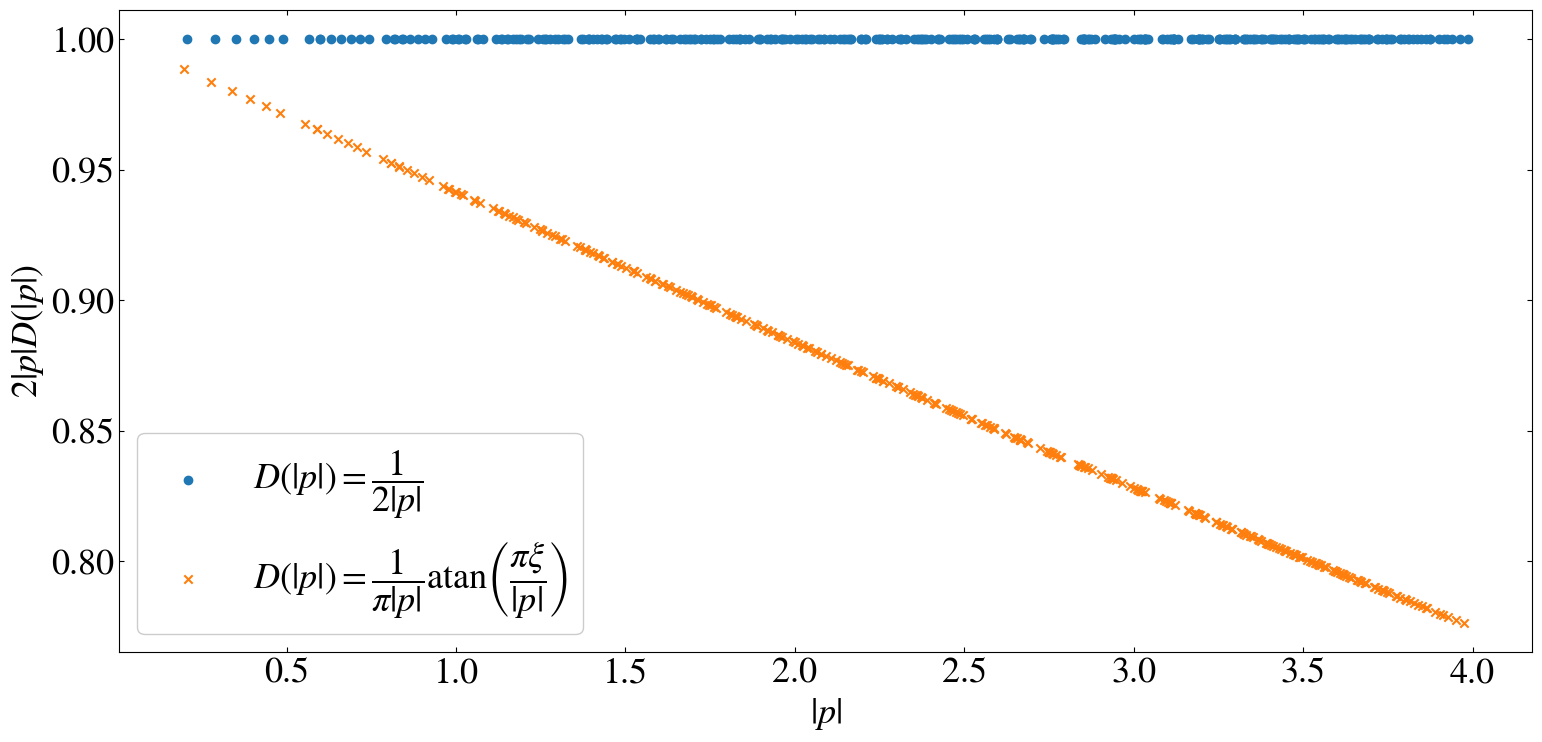

In [13]:
fig  = plt.figure(figsize=(16,8))
ax = plt.gca()
 
D_tree = 1/(2*q)
D_tree_atan = 1/(np.pi*q) * np.arctan(np.pi*3.453/q)

sort = np.argsort(q)

ax.scatter(q[sort]+0.01,2*q[sort]*D_tree[sort],ls='-',label="$D(|p|)=\dfrac{1}{2|p|}$")
ax.scatter(q[sort],2*q[sort]*D_tree_atan[sort],ls='-',marker='x',label=r"$D(|p|)=\dfrac{1}{\pi|p|}\mathrm{atan}\left(\dfrac{\pi\xi}{|p|}\right)$")

ax.legend()

ax.set_ylabel('$2|p|D(|p|)$')
#plt.yticks([])
ax.set_xlabel('$|p|$')

#plt.ylim(0,6)
#plt.yscale('log')
plt.tight_layout()

In [14]:
def vo_fit(x,Z,M,b):
    return Z*x/np.sqrt(x**4 + M**4)

def gauss(x,Z,mu,sigma):
    return Z*np.exp(-0.5*((x-mu)/sigma)**2)

[3.06037495 0.06949014 2.29113026]
[ 1.63269652 -0.23072091  1.45613984]
[ 1.65716912 -0.21238172  1.50979004]
[ 1.6455629  -0.25418854  1.52949162]
[ 1.62488888 -0.28557197  1.52143495]
[ 1.73783492 -0.25205284  1.60030303]
[ 1.72007252 -0.26590038  1.59115532]
[17.28633353  4.16837574  0.4371997 ]
[6.87066797 2.3455882  0.32560055]
[7.04128005 2.43840806 0.33723731]
[8.77813476 2.778633   0.33430556]
[10.11926371  2.99546082  0.32816099]
[10.8334143   3.13668087  0.34264167]
[11.36548818  3.21797227  0.34152439]
[0.77196774 0.88586088]
[0.78550946 0.85521349]
[0.75435615 0.84990602]
[0.74743602 0.85920959]
[0.75124269 0.86554248]
[0.74991856 0.86784573]
[0.74825909 0.86704529]


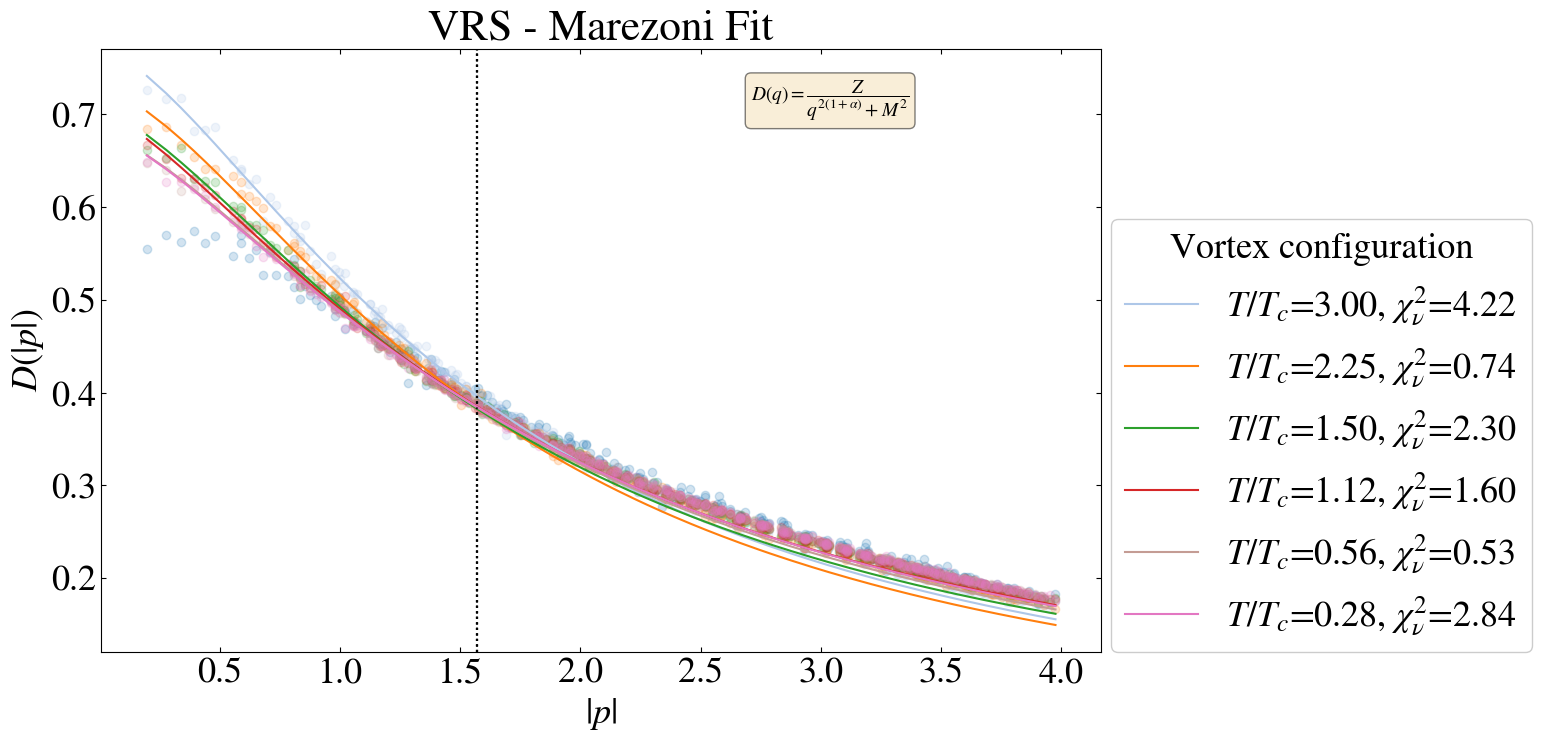

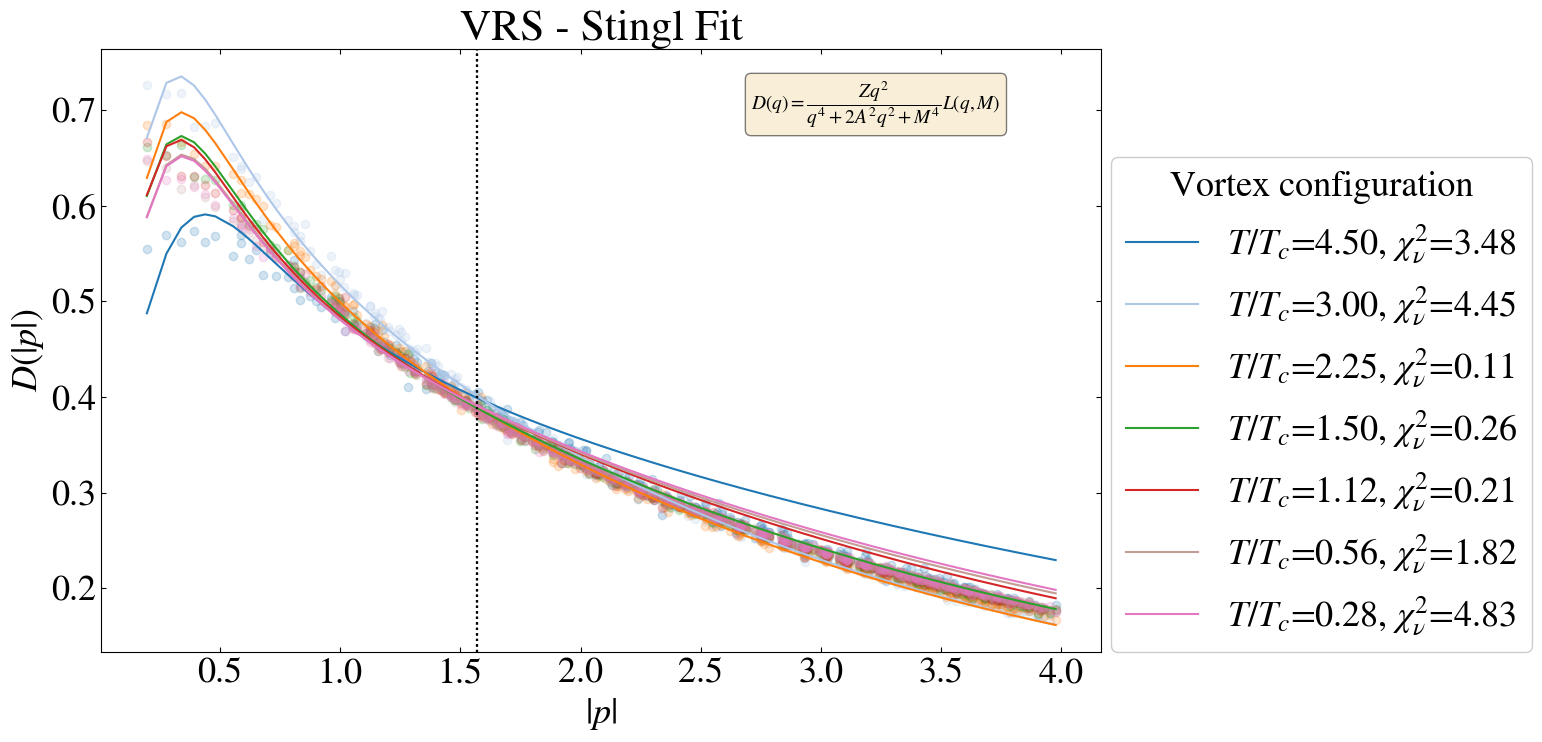

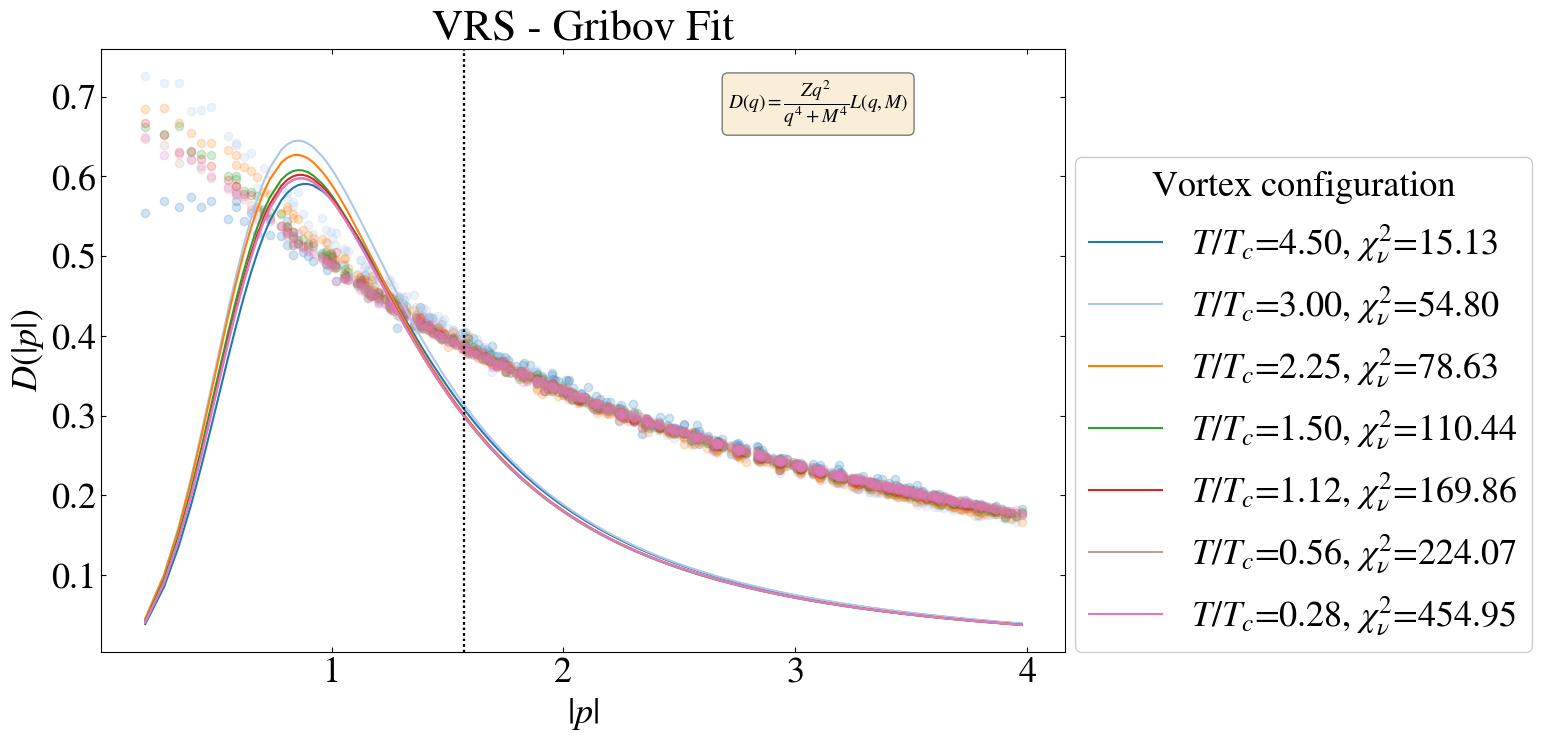

In [15]:
fits = {"Marezoni":view_gluon.marezoni, "Gribov":view_gluon.gribov, "Stingl":view_gluon.stingl}
forms = {"Marezoni":r"$D(q)=\dfrac{Z}{q^{2(1+\alpha)} + M^2}$", "Gribov":"$D(q)=\dfrac{Zq^2}{q^4 + M^4}L(q,M)$", "Stingl":"$D(q)=\dfrac{Zq^2}{q^4 + 2A^2q^2 + M^4}L(q,M)$"}

fit_results = {}

for name in ["Marezoni","Stingl",'Gribov']:

    plt.figure(figsize=(16,8))
    ax = plt.gca()

    fit = fits[name]
    
    fit_Z = []
    fit_M = []
    fit_Nt = []
    
    for pos,Nt in enumerate(results.keys()):
        q = results[Nt]['q'].copy()
        q = np.asarray([np.linalg.norm(qi[1:]) for qi in q[q[:,0]==0][1:]])
        D = results[Nt]['f'].copy()        
        
        cut = q < np.pi/2
    
        try:
            popt,pcov = so.curve_fit(fit,q[cut],np.asarray([d.mean for d in D[cut]]),sigma=np.asarray([d.sdev for d in D[cut]]), absolute_sigma=True)
            ax.plot(q[sort],fit(q[sort],*popt),label = f"$T/T_c$={36/Nt:.2f}, $\chi^2_\\nu$={chisq:.2f}",color=c[Nt])
            fit_Z.append(gv.gvar(popt[0],np.sqrt(np.diag(pcov)[0])))
            fit_M.append(gv.gvar(popt[-1],np.sqrt(np.diag(pcov)[-1])))
            fit_Nt.append(Nt)
        except:
            pass
        print(popt)
        chisq = view_gluon.chisq(np.asarray([d.mean for d in D]),fit(q,*popt),np.asarray([d.sdev for d in D]), ddof=len(D)-3)
    
        #print(Nt, popt, chisq)
    
        ax.scatter(q,np.asarray([d.mean for d in D]),alpha=0.2,color=c[Nt])
    
        sort = np.argsort(q)
    
        ax.axvline(np.pi/2,0,1,ls=':',c='k',alpha=0.5)

    ax.text(0.65, 0.95, forms[name], transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.title(f"{mode} - {name} Fit")    
    plt.legend(loc=(1.01,0),title='Vortex configuration')
    plt.ylabel('$D(|p|)$')
    plt.xlabel('$|p|$')
    
    fit_results[name] = {}
    
    fit_results[name]['Z'] = fit_Z
    fit_results[name]['M'] = fit_M
    fit_results[name]['Nt'] = fit_Nt

(0.0, 2.5)

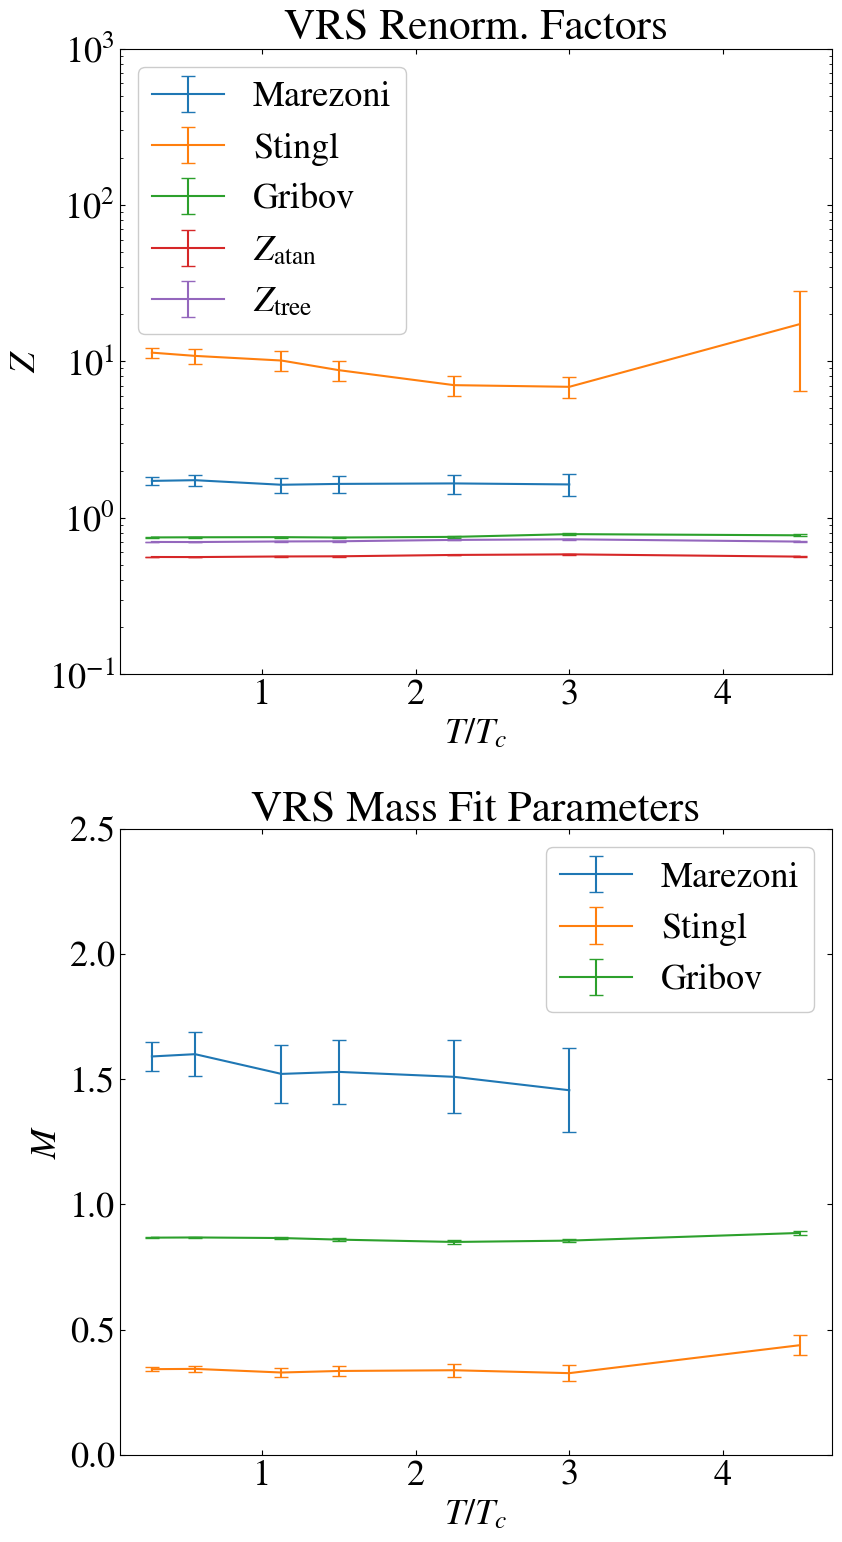

In [16]:
fig, ax = plt.subplots(2,1,figsize=(9,16))
for name in fit_results.keys():
    fit_Z = fit_results[name]['Z']
    fit_M = fit_results[name]['M']
    fit_Nt = fit_results[name]["Nt"]

    ax[0].errorbar([36/Nt for Nt in fit_Nt],[p.mean for p in fit_Z],[p.sdev for p in fit_Z],label=name)
    ax[1].errorbar([36/Nt for Nt in fit_Nt],[p.mean for p in fit_M],[p.sdev for p in fit_M],label=name)
    
ax[0].errorbar([36/Nt for Nt in results.keys()],[Z.mean for Z in Z_fit_arctan_list],[Z.sdev for Z in Z_fit_arctan_list],ls='-',label =r"$Z_\mathrm{atan}$")
ax[0].errorbar([36/Nt for Nt in results.keys()],[Z.mean for Z in Z_fit_list],[Z.sdev for Z in Z_fit_list],ls='-',label =r"$Z_\mathrm{tree}$")

    
ax[0].legend()
ax[1].legend()
ax[0].set_title(f"{mode} Renorm. Factors")
ax[1].set_title(f"{mode} Mass Fit Parameters")

ax[0].set_ylabel('$Z$')
ax[1].set_ylabel('$M$')

ax[0].set_xlabel('$T/T_c$')
ax[1].set_xlabel('$T/T_c$')
ax[0].set_yscale('log')

ax[0].set_ylim(1e-1,1e3)
ax[1].set_ylim(0,2.5)

In [17]:
Z_fit_list

[0.7038(53),
 0.7279(45),
 0.7214(39),
 0.7070(31),
 0.7053(27),
 0.6991(19),
 0.6999(13)]

In [18]:
fit_results["Gribov"]

{'Z': [0.772(12),
  0.7855(91),
  0.7544(75),
  0.7474(61),
  0.7512(54),
  0.7499(38),
  0.7483(26)],
 'M': [0.8859(92),
  0.8552(74),
  0.8499(62),
  0.8592(51),
  0.8655(44),
  0.8678(31),
  0.8670(21)],
 'Nt': [8, 12, 16, 24, 32, 64, 128]}